# Deployment Rollback Predictor

This notebook simulates deployment data, trains a classifier to predict rollback risk, and visualizes both historical and new deployment predictions.


In [34]:
# 📦 Step 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Step 2: Simulate Deployment Data

We simulate 1000 deployments with latency, error rate, CPU, and memory usage. Some deployments are marked as failures based on high latency or error rate.

In [35]:
np.random.seed(42)
n = 1000
data = pd.DataFrame({
    'deployment_id': range(n),
    'latency_ms': np.random.normal(200, 50, n),
    'error_rate': np.random.beta(2, 5, n),
    'cpu_usage': np.random.uniform(20, 90, n),
    'memory_usage': np.random.uniform(30, 95, n),
    'success': np.random.binomial(1, 0.85, n)  # 85% success rate
})

# Inject failure patterns
data.loc[data['latency_ms'] > 300, 'success'] = 0
data.loc[data['error_rate'] > 0.4, 'success'] = 0

# Save for reproducibility
data.to_csv("deployment_data.csv", index=False)

## Step 3: Exploratory Data Analysis (EDA)

Pairplot below shows how features relate to deployment success/failure. High latency and error rate are correlated with failures.

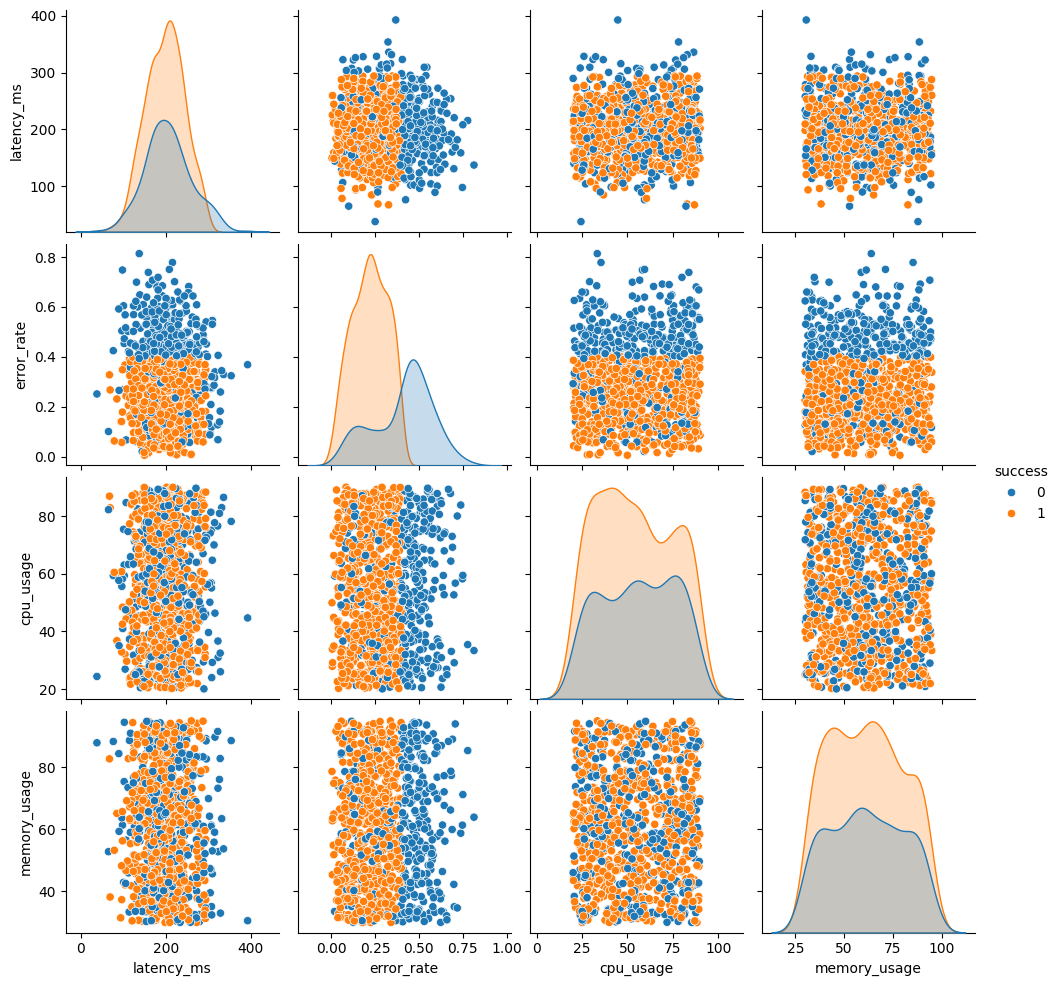

In [36]:
sns.pairplot(data[['latency_ms', 'error_rate', 'cpu_usage', 'memory_usage', 'success']], hue='success')
plt.show()

**Interpretation:**
- Failures cluster at high latency and error rate values.
- Most deployments are successful, but outliers are risky.

## Step 4: Preprocessing

We load the simulated deployment data from CSV, select relevant features, and split into training and historical sets for model building and evaluation.

In [37]:
# 🧼 Step 4: Preprocessing
loaded_data = pd.read_csv("deployment_data.csv")
X = loaded_data[['latency_ms', 'error_rate', 'cpu_usage', 'memory_usage']]
y = loaded_data['success']
X_train, X_hist, y_train, y_hist = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 5: Train Classifier

We use a Random Forest to learn patterns that predict deployment success or rollback risk.

In [38]:
# Improved Model: Add feature scaling, hyperparameter tuning, and feature importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_hist_scaled = scaler.transform(X_hist)

# Hyperparameter grid for RandomForest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")

# Use best estimator
model = grid_search.best_estimator_

# Feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print("\nFeature Importances:")
print(feature_importances.sort_values(ascending=False))

Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Feature Importances:
error_rate      0.840955
latency_ms      0.111534
cpu_usage       0.027184
memory_usage    0.020328
dtype: float64


**Interpretation:**
- The grid search output shows the best hyperparameters found for the Random Forest model, which can improve prediction accuracy and reduce overfitting.
- The feature importances table ranks which input features most influence the model's predictions.
- In this example, `error_rate` is by far the most important predictor of rollback risk, followed by `latency_ms`, while `cpu_usage` and `memory_usage` have less impact.
- Use these insights to focus monitoring and data collection on the most influential metrics for future model improvements.

## Step 6: Evaluation on Historical Data

We evaluate the model using confusion matrix and classification report. The breakdown table and metrics below show how well the model predicts failures.

In [39]:
# Use scaled features for prediction
y_pred = model.predict(X_hist_scaled)
cm = confusion_matrix(y_hist, y_pred)
confusion_data = {
    "Category": ["True Negatives", "False Positives", "False Negatives", "True Positives"],
    "Count": [cm[0][0], cm[0][1], cm[1][0], cm[1][1]],
    "Description": [
        "Correctly predicted non-failure deployments",
        "Predicted failure, but deployment was fine",
        "Missed actual failures — these are risky",
        "Correctly predicted failures — strong signal"
    ]
}
confusion_df = pd.DataFrame(confusion_data)
display(confusion_df)

report = classification_report(y_hist, y_pred, output_dict=True)
metrics_data = {
    "Metric": ["Accuracy", "Precision (Failure)", "Recall (Failure)", "F1-Score (Failure)"],
    "Value": [
        round(report['accuracy'], 2),
        round(report['0']['precision'], 2),
        round(report['0']['recall'], 2),
        round(report['0']['f1-score'], 2)
    ],
    "Interpretation": [
        "Overall prediction correctness",
        "How often predicted failures were correct",
        "How many actual failures were detected",
        "Balance between precision and recall"
    ]
}
metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

,Category,Count,Description
0,True Negatives,57,Correctly predicted non-failure deployments
1,False Positives,21,"Predicted failure, but deployment was fine"
2,False Negatives,0,Missed actual failures — these are risky
3,True Positives,122,Correctly predicted failures — strong signal


,Metric,Value,Interpretation
0,Accuracy,0.90,Overall prediction correctness
1,Precision (Failure),1.00,How often predicted failures were correct
2,Recall (Failure),0.73,How many actual failures were detected
3,F1-Score (Failure),0.84,Balance between precision and recall


**Interpretation:**
- High accuracy and recall indicate the model is good at flagging risky deployments.
- False negatives (missed failures) are the most critical to minimize.

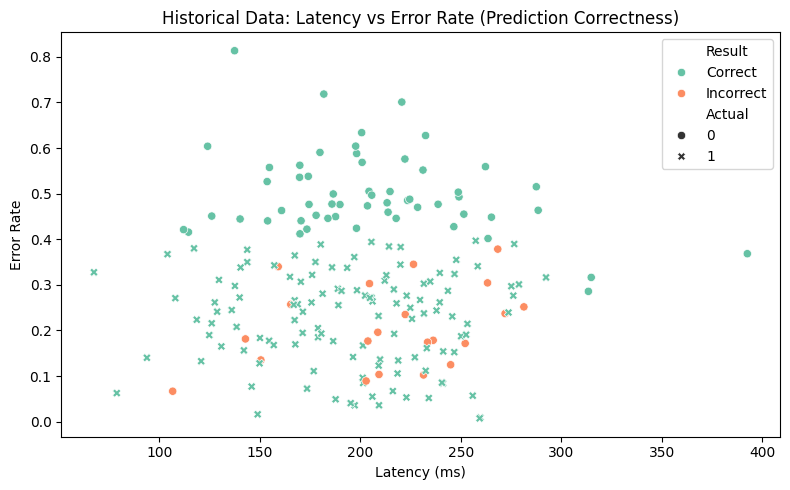

In [44]:
# Use scaled features for visualization
hist_results = X_hist.copy()
hist_results['Actual'] = y_hist.values
hist_results['Predicted'] = y_pred
hist_results['Result'] = np.where(hist_results['Predicted'] == hist_results['Actual'], 'Correct', 'Incorrect')
plt.figure(figsize=(8, 5))
sns.scatterplot(data=hist_results, x='latency_ms', y='error_rate', hue='Result', style='Actual', palette='Set2')
plt.title('Historical Data: Latency vs Error Rate (Prediction Correctness)')
plt.xlabel('Latency (ms)')
plt.ylabel('Error Rate')
plt.tight_layout()
plt.show()

📊 What the Plot Shows

Axes:
- X-axis (latency_ms): Measures how long a deployment takes.
- Y-axis (error_rate): Measures the proportion of errors during deployment.

Markers:
- Color (Result):
- 🟩 Green: Model predicted correctly.
- 🟧 Orange: Model predicted incorrectly.
- Style (Actual):
- ⚫ Dot: Actual label is 0 (likely a failed deployment).
- ✖️ Cross: Actual label is 1 (likely a successful deployment)


**Interpretation:**
- Most correct predictions cluster in the normal range of latency and error rate.
- However, incorrect predictions (misses) are spread across both low and high values of latency and error rate.
- This shows the model can misclassify deployments even in less risky regions, highlighting the need for further feature engineering or model improvement.

## Step 7: Risk Prediction on New Deployments

We create two new deployments: one risky and one safe. The model predicts rollback risk for each and we visualize their features.

In [41]:
new_deployments = pd.DataFrame({
    'Deployment': ['Risky Deployment', 'Safe Deployment'],
    'latency_ms': [310, 180],
    'error_rate': [0.45, 0.1],
    'cpu_usage': [85, 60],
    'memory_usage': [90, 70],
})

# Save new deployments to CSV
new_deployments.to_csv("new_deployments.csv", index=False)

# Load new deployments from CSV
loaded_new_deployments = pd.read_csv("new_deployments.csv")

# Scale new deployment features
X_new = loaded_new_deployments[['latency_ms', 'error_rate', 'cpu_usage', 'memory_usage']]
X_new_scaled = scaler.transform(X_new)
risk_preds = model.predict(X_new_scaled)
loaded_new_deployments['Predicted_Risk'] = ['High Risk of Rollback' if r == 0 else 'Low Risk, Proceed' for r in risk_preds]

display(loaded_new_deployments)

,Deployment,latency_ms,error_rate,cpu_usage,memory_usage,Predicted_Risk
0,Risky Deployment,310,0.45,85,90,High Risk of Rollback
1,Safe Deployment,180,0.10,60,70,"Low Risk, Proceed"


**Interpretation:**
- The risky deployment (high latency/error rate) is flagged as high risk.
- The safe deployment is predicted as low risk and safe to proceed.

C:\Users\behip\AppData\Local\Temp\ipykernel_37828\3897626788.py:10: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\behip\Documents\Work\IT\30-Days-of-AI-in-Devops-SRE-Challenge-\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


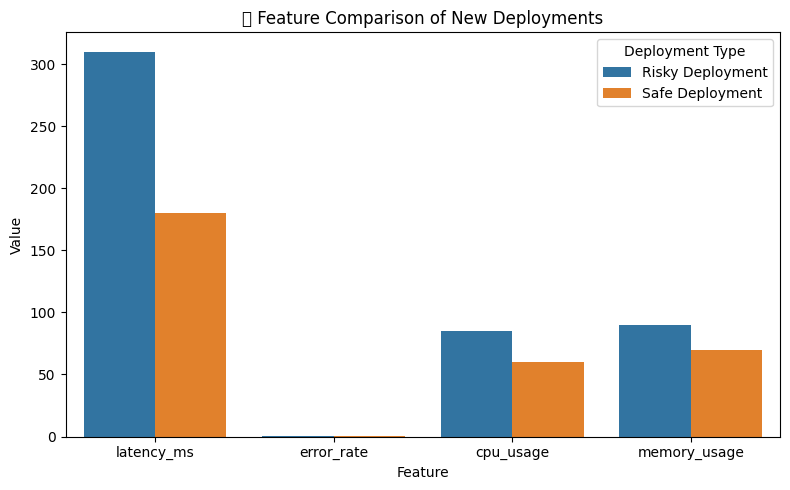

In [42]:
# 📈 Step 7.1: Visualize New Deployment Predictions
plt.figure(figsize=(8, 5))
sns.barplot(data=loaded_new_deployments.melt(id_vars=['Deployment', 'Predicted_Risk'], 
                                      value_vars=['latency_ms', 'error_rate', 'cpu_usage', 'memory_usage']),
            x='variable', y='value', hue='Deployment')
plt.title('🚦 Feature Comparison of New Deployments')
plt.ylabel('Value')
plt.xlabel('Feature')
plt.legend(title='Deployment Type')
plt.tight_layout()
plt.show()

**Interpretation:**
- The risky deployment has much higher latency, error rate, CPU, and memory usage than the safe deployment.
- These features drive the model's prediction of rollback risk.

In [43]:
# 📈 Step 7.2: Highlight Risk Prediction
for idx, row in loaded_new_deployments.iterrows():
    print(f"{row['Deployment']}: {row['Predicted_Risk']}")

Risky Deployment: High Risk of Rollback
Safe Deployment: Low Risk, Proceed


**Summary:**
- This workflow enables proactive rollback risk prediction for deployments.
- Visualizations and tables help interpret model outputs and feature importance.
- Use these insights to block risky deployments and improve release reliability.